In [1]:
%load_ext PWE_NB_Extension

In [59]:
from PW_explorer.load_worlds import load_worlds
from PW_explorer.visualize import PWEVisualization
from PW_explorer.nb_helper import ASPRules
from PW_explorer.query import PWEQuery
from PW_explorer.helper import pw_slicer
import numpy as np

In [3]:
import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

In [86]:
# Fixes positions of the nodes, so we get nicer looking outputs with consistent node placement.
def mod_g(g):
    g.nodes['a']['pos'] = '"1,2!"'
    g.nodes['b']['pos'] = '"2,1!"'
    g.nodes['c']['pos'] = '"2,3!"'
    g.nodes['d']['pos'] = '"3,1!"'
    g.nodes['e']['pos'] = '"3,3!"'
    g.nodes['f']['pos'] = '"4,2!"'
    return g

What questions do we want to answer? What do we want to accomplish?

### A simple graph

Let us consider a small graph.

In [4]:
%%dlv --donot-run -exp e1 --donot-display_input -lci g_e1

% A simple base graph:
% a ->  b -> d  
%  \     \    \
%   \->c  \->e-\->f

% graphviz graph graph_type=directed
% graphviz edge e(HEAD,TAIL) color=black ord=3

e(a,b). e(a,c).
e(b,d). e(b,e).
e(d,f). e(e,f).

In [5]:
%dlv --run -l g_e1 -exp e1 --donot-display_input 

Output:


'{e(a,b), e(a,c), e(b,d), e(b,e), e(d,f), e(e,f)}'

In [6]:
e1['pw_rel_dfs'], e1['rel_schemas'], e1['pw_objects'] = load_worlds(e1['asp_soln'], e1['meta_data'], reasoner='dlv')

Number of Models: 1


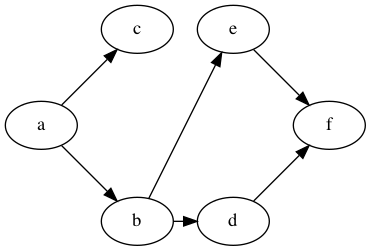

In [105]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(e1['pw_rel_dfs'], e1['meta_data']['graphviz'])), layout='neato')

#### Potential Additional Edges

In [54]:
%%dlv --donot-run --donot-display_input -lci g_e2

% Include/Exclude some edges:
e(c,d). e(c,e).

In [9]:
%dlv --run -l g_e1 g_e2 -exp e2 --donot-display_input

Output:


'{e(a,b), e(a,c), e(b,d), e(b,e), e(c,d), e(c,e), e(d,f), e(e,f)}'

In [10]:
e2['pw_rel_dfs'], e2['rel_schemas'], e2['pw_objects'] = load_worlds(e2['asp_soln'], e2['meta_data'], reasoner='dlv')

Number of Models: 1


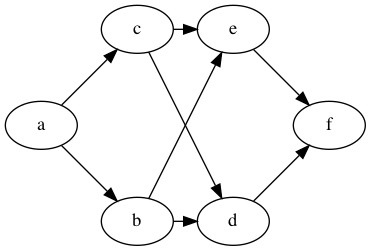

In [106]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(e2['pw_rel_dfs'], e2['meta_data']['graphviz'])), layout='neato')

### Basic Transitive Closure on the above two graphs

In [12]:
%%dlv --donot-run --donot-display_input -lci tc

% Playing with transitive closure and its provenance..

% Simple (right) recursive rules from computing the transitive closure tc of e:

% graphviz edge tc(HEAD,TAIL) color=blue ord=1
tc(X,Y) :- e(X,Y).
tc(X,Y) :- e(X,Z), tc(Z,Y).

In [13]:
%dlv --run -l g_e1 tc -exp tc_e1 --donot-display_input

Output:


'{e(a,b), e(a,c), e(b,d), e(b,e), e(d,f), e(e,f), tc(a,b), tc(a,c), tc(a,d), tc(a,e), tc(a,f), tc(b,d), tc(b,e), tc(b,f), tc(d,f), tc(e,f)}'

In [14]:
tc_e1['pw_rel_dfs'], tc_e1['rel_schemas'], tc_e1['pw_objects'] = load_worlds(tc_e1['asp_soln'], tc_e1['meta_data'], reasoner='dlv')

Number of Models: 1


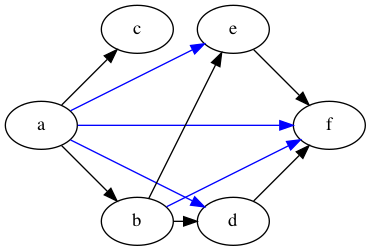

In [107]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(tc_e1['pw_rel_dfs'], tc_e1['meta_data']['graphviz'])), layout='neato')

In [16]:
%dlv --run -l g_e1 g_e2 tc -exp tc_e2 --donot-display_input

Output:


'{e(a,b), e(a,c), e(b,d), e(b,e), e(c,d), e(c,e), e(d,f), e(e,f), tc(a,b), tc(a,c), tc(a,d), tc(a,e), tc(a,f), tc(b,d), tc(b,e), tc(b,f), tc(c,d), tc(c,e), tc(c,f), tc(d,f), tc(e,f)}'

In [17]:
tc_e2['pw_rel_dfs'], tc_e2['rel_schemas'], tc_e2['pw_objects'] = load_worlds(tc_e2['asp_soln'], tc_e2['meta_data'], reasoner='dlv')

Number of Models: 1


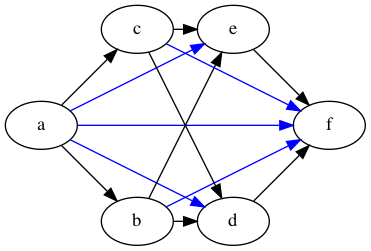

In [108]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(tc_e2['pw_rel_dfs'], tc_e2['meta_data']['graphviz'])), layout='neato')

### Transitive Closure (along with some provenance)

In [19]:
%%dlv --donot-run --donot-display_input -lci tc4

% Playing with transitive closure and its provenance..

% EXAMPLE 1: 
% $ dlv tc4.dlv e1.dlv -filter=q -silent
% {q(a,b), q(b,d), q(b,e), q(d,f), q(e,f)}

% EXAMPLE 2:
% $ dlv tc4.dlv e1.dlv e2.dlv -filter=q -silent
% {q(a,b), q(a,c), q(b,d), q(b,e), q(c,d), q(c,e), q(d,f), q(e,f)}

% Now a version that also reports 'intermediate' edges IX->IY, i.e.,
% tc4(X,Y, IX, IY) holds iff (1) Y is reachable from X via an e-path,
% .. and (2) the edge (IX,IY) is on some such path from X to Y: 

% BASE CASE:
tc4(X,Y, X,Y) :- e(X,Y).                    % (B)

% In the RECURSIVE CASE, we need to keep all intermediate edges we already have:
tc4(X,Y, IX,IY) :- e(X,Z), tc4(Z,Y, IX,IY). % (R1)

% ... plus any "new" edges we get:  
tc4(X,Y, X,Z) :- e(X,Z), tc4(Z,Y, _,_).     % (R2) 

% Output relation: report all intermediate edges on some path from a to f: 
q(IX,IY) :- tc4(a,f,IX,IY).

% graphviz edge q(HEAD,TAIL) color=blue ord=5

% EXERCISE:
% Do we need both (R1) and (R2) for this to work?
% => Why (or why not)? 


In [20]:
%dlv --run -l g_e1 tc4 -exp tc4_e1 --donot-display_input

Output:


'{e(a,b), e(a,c), e(b,d), e(b,e), e(d,f), e(e,f), tc4(a,b,a,b), tc4(a,c,a,c), tc4(a,d,a,b), tc4(a,d,b,d), tc4(a,e,a,b), tc4(a,e,b,e), tc4(a,f,a,b), tc4(a,f,b,d), tc4(a,f,b,e), tc4(a,f,d,f), tc4(a,f,e,f), tc4(b,d,b,d), tc4(b,e,b,e), tc4(b,f,b,d), tc4(b,f,b,e), tc4(b,f,d,f), tc4(b,f,e,f), tc4(d,f,d,f), tc4(e,f,e,f), q(a,b), q(b,d), q(b,e), q(d,f), q(e,f)}'

In [21]:
tc4_e1['pw_rel_dfs'], tc4_e1['rel_schemas'], tc4_e1['pw_objects'] = load_worlds(tc4_e1['asp_soln'], tc4_e1['meta_data'], reasoner='dlv')

Number of Models: 1


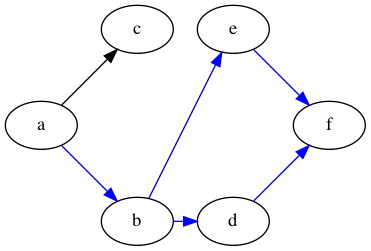

In [109]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(tc4_e1['pw_rel_dfs'], tc4_e1['meta_data']['graphviz'])), layout='neato')

In [23]:
%dlv --run -l g_e1 g_e2 tc4 -exp tc4_e2 --donot-display_input

Output:


'{e(a,b), e(a,c), e(b,d), e(b,e), e(c,d), e(c,e), e(d,f), e(e,f), tc4(a,b,a,b), tc4(a,c,a,c), tc4(a,d,a,b), tc4(a,d,a,c), tc4(a,d,b,d), tc4(a,d,c,d), tc4(a,e,a,b), tc4(a,e,a,c), tc4(a,e,b,e), tc4(a,e,c,e), tc4(a,f,a,b), tc4(a,f,a,c), tc4(a,f,b,d), tc4(a,f,b,e), tc4(a,f,c,d), tc4(a,f,c,e), tc4(a,f,d,f), tc4(a,f,e,f), tc4(b,d,b,d), tc4(b,e,b,e), tc4(b,f,b,d), tc4(b,f,b,e), tc4(b,f,d,f), tc4(b,f,e,f), tc4(c,d,c,d), tc4(c,e,c,e), tc4(c,f,c,d), tc4(c,f,c,e), tc4(c,f,d,f), tc4(c,f,e,f), tc4(d,f,d,f), tc4(e,f,e,f), q(a,b), q(a,c), q(b,d), q(b,e), q(c,d), q(c,e), q(d,f), q(e,f)}'

In [24]:
tc4_e2['pw_rel_dfs'], tc4_e2['rel_schemas'], tc4_e2['pw_objects'] = load_worlds(tc4_e2['asp_soln'], tc4_e2['meta_data'], reasoner='dlv')

Number of Models: 1


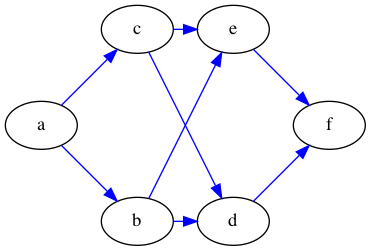

In [110]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(tc4_e2['pw_rel_dfs'], tc4_e2['meta_data']['graphviz'])), layout='neato')

### Problem at Hand

#### Simple Di-Graph with two components

What are the unique sets of ways information can flow from A to F, given information can only flow in one direction between a pair of nodes.

In [26]:
%%dlv --donot-run --donot-display_input -lci g_e3

% Now let's create some 

% graphviz graph graph_type=directed
% graphviz edge e(HEAD,TAIL) color=black ord=3

% Given edges: 
e(a,b).
e(a,c).
e(d,f).
e(e,f).

In [27]:
%dlv --run -l g_e3 -exp e3 --donot-display_input

Output:


'{e(a,b), e(a,c), e(d,f), e(e,f)}'

In [28]:
e3['pw_rel_dfs'], e3['rel_schemas'], e3['pw_objects'] = load_worlds(e3['asp_soln'], e3['meta_data'], reasoner='dlv')

Number of Models: 1


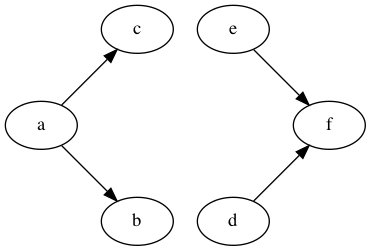

In [104]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(e3['pw_rel_dfs'], e3['meta_data']['graphviz'])), layout='neato')

#### Enlisting potential edge additions

In [30]:
%%dlv --donot-run --donot-display_input -lci gen_new_edges

% Which nodes All nodes: 
% n(X) :- e(X,_).
% n(X) :- e(_,X).
n(b). n(c). n(d). n(e). 
    
% Let's use a GENERATOR: For every pair of edges (X,Y) in a given set of nodes n/1,
% ... let's either have the edge "in" (= member of i/2) or "out" (= in o/2):
i(X,Y) v o(X,Y) :- n(X), n(Y), X!=Y. 

% Now let's use the same tc + provenance (= tc with 4 arguments) rules:

% First: let's copy all generated "in" pairs from i/2 to e/2: 
e(X,Y) :- i(X,Y).

In [31]:
%dlv -l g_e3 gen_new_edges --donot-display_input --donot-display_output -exp new_edges

In [32]:
new_edges['pw_rel_dfs'], new_edges['rel_schemas'], new_edges['pw_objects'] = load_worlds(new_edges['asp_soln'], new_edges['meta_data'], reasoner='dlv')

Number of Models: 4096


4096 

= 2^12 (For each of the 4(3) = 12 ordered pairs of nodes, we have 2 options, add it or don't) 

= 4^6 (For each of the (4 choose 2)=6 pairs of nodes, we have 3 choices: add xy, add yx, add neither or add both)

In [33]:
ASPRules("\n".join(new_edges['asp_soln'].splitlines()[:2]))

'{n(b), n(c), n(d), n(e), e(a,b), e(a,c), e(d,f), e(e,f), i(b,c), i(b,d), i(b,e), i(c,b), i(c,d), i(c,e), i(d,b), i(d,c), i(d,e), i(e,b), i(e,c), i(e,d), e(b,c), e(b,d), e(b,e), e(c,b), e(c,d), e(c,e), e(d,b), e(d,c), e(d,e), e(e,b), e(e,c), e(e,d)}\n{n(b), n(c), n(d), n(e), e(a,b), e(a,c), e(d,f), e(e,f), o(b,c), i(b,d), i(b,e), i(c,b), i(c,d), i(c,e), i(d,b), i(d,c), i(d,e), i(e,b), i(e,c), i(e,d), e(b,d), e(b,e), e(c,b), e(c,d), e(c,e), e(d,b), e(d,c), e(d,e), e(e,b), e(e,c), e(e,d)}'

In [34]:
%%dlv --donot-run --donot-display_input -lci remove_back_edges

% Let's also say that if an edge X,Y is "in", then the reverse edge Y,X cannot be in.
% This is just to show how one can easily add new constraints (reducing the set of PWs / solutions):
:- i(X,Y), i(Y,X).

In [35]:
%dlv -l g_e3 remove_back_edges gen_new_edges --donot-display_input --donot-display_output -exp new_edges

In [36]:
new_edges['pw_rel_dfs'], new_edges['rel_schemas'], new_edges['pw_objects'] = load_worlds(new_edges['asp_soln'], new_edges['meta_data'], reasoner='dlv')

Number of Models: 729


729  

= 3^6  (For each of the (4 choose 2)=6 unordered pairs of nodes, we have 3 choices: add xy, add yx or add neither)

In [37]:
ASPRules("\n".join(new_edges['asp_soln'].splitlines()[:2]))

'{n(b), n(c), n(d), n(e), e(a,b), e(a,c), e(d,f), e(e,f), o(b,c), o(b,d), o(b,e), i(c,b), o(c,d), o(c,e), i(d,b), i(d,c), o(d,e), i(e,b), i(e,c), i(e,d), e(c,b), e(d,b), e(d,c), e(e,b), e(e,c), e(e,d)}\n{n(b), n(c), n(d), n(e), e(a,b), e(a,c), e(d,f), e(e,f), i(b,c), o(b,d), o(b,e), o(c,b), o(c,d), o(c,e), i(d,b), i(d,c), o(d,e), i(e,b), i(e,c), i(e,d), e(b,c), e(d,b), e(d,c), e(e,b), e(e,c), e(e,d)}'

In [38]:
%dlv -l g_e3 gen_new_edges remove_back_edges tc4 --donot-display_input --donot-display_output -exp potential_graphs

In [39]:
potential_graphs['pw_rel_dfs'], potential_graphs['rel_schemas'], potential_graphs['pw_objects'] = load_worlds(potential_graphs['asp_soln'], potential_graphs['meta_data'], reasoner='dlv')

Number of Models: 729


In [40]:
ASPRules("\n".join(potential_graphs['asp_soln'].splitlines()[:2]))

'{n(b), n(c), n(d), n(e), e(a,b), e(a,c), e(d,f), e(e,f), tc4(a,b,a,b), tc4(a,c,a,c), tc4(d,f,d,f), tc4(e,f,e,f), i(b,c), o(b,d), o(b,e), o(c,b), o(c,d), i(c,e), i(d,b), i(d,c), o(d,e), i(e,b), o(e,c), i(e,d), e(b,c), e(c,e), e(d,b), e(d,c), e(e,b), e(e,d), tc4(b,c,b,c), tc4(c,e,c,e), tc4(d,b,d,b), tc4(d,c,d,c), tc4(e,b,e,b), tc4(e,d,e,d), tc4(c,f,d,f), tc4(e,f,d,f), tc4(b,f,d,f), tc4(c,f,e,f), tc4(d,f,e,f), tc4(b,f,e,f), tc4(a,c,b,c), tc4(d,c,b,c), tc4(e,c,b,c), tc4(c,c,b,c), tc4(a,e,c,e), tc4(d,e,c,e), tc4(e,e,c,e), tc4(b,e,c,e), tc4(c,b,d,b), tc4(e,b,d,b), tc4(b,b,d,b), tc4(c,c,d,c), tc4(e,c,d,c), tc4(b,c,d,c), tc4(c,b,e,b), tc4(d,b,e,b), tc4(b,b,e,b), tc4(c,d,e,d), tc4(d,d,e,d), tc4(b,d,e,d), tc4(a,b,d,b), tc4(a,f,e,f), tc4(a,f,d,f), tc4(a,d,e,d), tc4(a,b,e,b), tc4(a,c,d,c), tc4(e,f,e,d), tc4(c,f,c,e), tc4(a,c,a,b), tc4(d,c,d,b), tc4(e,c,e,b), tc4(a,d,a,b), tc4(d,d,d,b), tc4(e,d,e,b), tc4(a,e,a,b), tc4(d,e,d,b), tc4(e,e,e,b), tc4(a,b,a,c), tc4(d,b,d,c), tc4(b,b,b,c), tc4(a,d,a,c), tc4(d,d,d,c), tc4(b,d,b,c), tc4(a,e,a,c), tc4(d,e,d,c), tc4(b,e,b,c), tc4(e,b,e,d), tc4(e,c,e,d), tc4(e,e,e,d), tc4(c,b,c,e), tc4(c,c,c,e), tc4(c,d,c,e), tc4(a,b,b,c), tc4(a,e,b,c), tc4(a,d,b,c), tc4(a,f,c,e), tc4(a,d,c,e), tc4(a,c,c,e), tc4(a,b,c,e), tc4(b,f,c,e), tc4(b,d,c,e), tc4(b,c,c,e), tc4(b,b,c,e), tc4(b,b,d,c), tc4(b,e,d,c), tc4(b,e,d,b), tc4(b,d,d,c), tc4(b,d,d,b), tc4(b,c,d,b), tc4(b,e,e,d), tc4(b,e,e,b), tc4(b,f,e,d), tc4(b,d,e,b), tc4(b,c,e,d), tc4(b,c,e,b), tc4(b,b,e,d), tc4(c,b,b,c), tc4(c,e,b,c), tc4(c,d,b,c), tc4(c,b,d,c), tc4(c,e,d,c), tc4(c,e,d,b), tc4(c,d,d,c), tc4(c,d,d,b), tc4(c,c,d,b), tc4(c,e,e,d), tc4(c,e,e,b), tc4(c,f,e,d), tc4(c,d,e,b), tc4(c,c,e,d), tc4(c,c,e,b), tc4(c,b,e,d), tc4(d,b,b,c), tc4(d,e,b,c), tc4(d,d,b,c), tc4(d,f,c,e), tc4(d,d,c,e), tc4(d,c,c,e), tc4(d,b,c,e), tc4(d,e,e,d), tc4(d,e,e,b), tc4(d,f,e,d), tc4(d,d,e,b), tc4(d,c,e,d), tc4(d,c,e,b), tc4(d,b,e,d), tc4(e,b,b,c), tc4(e,e,b,c), tc4(e,d,b,c), tc4(e,f,c,e), tc4(e,d,c,e), tc4(e,c,c,e), tc4(e,b,c,e), tc4(e,b,d,c), tc4(e,e,d,c), tc4(e,e,d,b), tc4(e,d,d,c), tc4(e,d,d,b), tc4(e,c,d,b), tc4(a,f,a,b), tc4(d,f,d,b), tc4(e,f,e,b), tc4(a,f,a,c), tc4(d,f,d,c), tc4(b,f,b,c), tc4(a,b,d,c), tc4(a,b,e,d), tc4(a,c,d,b), tc4(a,c,e,b), tc4(a,c,e,d), tc4(a,d,d,b), tc4(a,d,d,c), tc4(a,d,e,b), tc4(a,f,b,c), tc4(a,f,e,d), tc4(a,e,d,b), tc4(a,e,d,c), tc4(a,e,e,b), tc4(a,e,e,d), tc4(b,f,d,c), tc4(b,f,d,b), tc4(b,f,e,b), tc4(c,f,b,c), tc4(c,f,d,c), tc4(c,f,d,b), tc4(c,f,e,b), tc4(d,f,b,c), tc4(d,f,e,b), tc4(e,f,b,c), tc4(e,f,d,c), tc4(e,f,d,b), tc4(a,f,e,b), tc4(a,f,d,c), tc4(a,f,d,b), q(e,b), q(d,c), q(d,b), q(e,d), q(b,c), q(e,f), q(d,f), q(a,b), q(a,c), q(c,e)}\n{n(b), n(c), n(d), n(e), e(a,b), e(a,c), e(d,f), e(e,f), tc4(a,b,a,b), tc4(a,c,a,c), tc4(d,f,d,f), tc4(e,f,e,f), i(b,c), o(b,d), o(b,e), o(c,b), i(c,d), i(c,e), i(d,b), o(d,c), o(d,e), i(e,b), o(e,c), i(e,d), e(b,c), e(c,d), e(c,e), e(d,b), e(e,b), e(e,d), tc4(b,c,b,c), tc4(c,d,c,d), tc4(c,e,c,e), tc4(d,b,d,b), tc4(e,b,e,b), tc4(e,d,e,d), tc4(c,f,d,f), tc4(e,f,d,f), tc4(b,f,d,f), tc4(c,f,e,f), tc4(d,f,e,f), tc4(b,f,e,f), tc4(a,c,b,c), tc4(d,c,b,c), tc4(e,c,b,c), tc4(c,c,b,c), tc4(a,d,c,d), tc4(d,d,c,d), tc4(e,d,c,d), tc4(b,d,c,d), tc4(a,e,c,e), tc4(d,e,c,e), tc4(e,e,c,e), tc4(b,e,c,e), tc4(c,b,d,b), tc4(e,b,d,b), tc4(b,b,d,b), tc4(c,b,e,b), tc4(d,b,e,b), tc4(b,b,e,b), tc4(c,d,e,d), tc4(d,d,e,d), tc4(b,d,e,d), tc4(a,b,d,b), tc4(a,f,e,f), tc4(a,f,d,f), tc4(a,d,e,d), tc4(a,b,e,b), tc4(c,f,c,d), tc4(e,f,e,d), tc4(c,f,c,e), tc4(a,c,a,b), tc4(d,c,d,b), tc4(e,c,e,b), tc4(a,d,a,b), tc4(d,d,d,b), tc4(e,d,e,b), tc4(a,e,a,b), tc4(d,e,d,b), tc4(e,e,e,b), tc4(a,b,a,c), tc4(b,b,b,c), tc4(a,d,a,c), tc4(b,d,b,c), tc4(a,e,a,c), tc4(b,e,b,c), tc4(c,b,c,d), tc4(e,b,e,d), tc4(c,c,c,d), tc4(e,c,e,d), tc4(c,e,c,d), tc4(e,e,e,d), tc4(c,b,c,e), tc4(c,c,c,e), tc4(c,d,c,e), tc4(a,b,b,c), tc4(a,e,b,c), tc4(a,d,b,c), tc4(a,b,c,d), tc4(a,e,c,d), tc4(a,f,c,e), tc4(a,f,c,d), tc4(a,d,c,e), tc4(a,c,c,e), tc4(a,c,c,d), tc4(a,b,c,e), tc4(b,b,c,d), tc

In [41]:
PWEQuery.difference_both_ways(dfs=potential_graphs['pw_rel_dfs'], rl_name='q_2', pw_id_1=1, pw_id_2=2, do_print=False)

,x1,x2
0,d,c
1,c,d


In [42]:
PWEQuery.difference_both_ways(dfs=potential_graphs['pw_rel_dfs'], rl_name='q_2', pw_id_1=1, pw_id_2=100, do_print=False)

,x1,x2
0,e,b
1,d,c
2,d,b
3,b,c
4,a,b


### Interested in unique a --> f path sets

##### Approach 1

In [43]:
groups = {}
q_2_df = potential_graphs['pw_rel_dfs']['q_2']
for pw_id in range(1, len(potential_graphs['pw_objects'])+1):
    pw_q_2_df = q_2_df[q_2_df['pw'] == pw_id]
    pw_q_rels = []
    for i, row in pw_q_2_df.iterrows():
        pw_q_rels.append((row['x1'], row['x2']))
    pw_q_rels = frozenset(pw_q_rels)
    if pw_q_rels not in groups:
        groups[pw_q_rels] = []
    groups[pw_q_rels].append(pw_id)

In [44]:
len(groups.keys())

266

##### Approach 2

In [45]:
# dist_matrix = np.zeros((len(potential_graphs['pw_objects']), len(potential_graphs['pw_objects'])))
# for i in range(len(potential_graphs['pw_objects'])):
#     for j in range(i+1, len(potential_graphs['pw_objects'])):
#         dist_matrix[i][j] = dist_matrix[j][i] = len(PWEQuery.difference_both_ways(dfs=potential_graphs['pw_rel_dfs'], rl_name='q_2', do_print=False, pw_id_1=i+1, pw_id_2=j+1))
# dist_matrix

This naive (but well-defined) way takes too long, so we do an equivalent version below, optimized for this particular problem

In [46]:
def get_pw_q_rels(q_2_df, pw_id):
    pw_q_2_df = q_2_df[q_2_df['pw'] == pw_id]
    pw_q_rels = []
    for i, row in pw_q_2_df.iterrows():
        pw_q_rels.append((row['x1'], row['x2']))
    return set(pw_q_rels)

def compare_q_sets(pw_1_q_set, pw_2_q_set):
    return len(pw_1_q_set-pw_2_q_set) + len(pw_2_q_set-pw_1_q_set)    

In [47]:
dist_matrix = np.zeros((len(potential_graphs['pw_objects']), len(potential_graphs['pw_objects'])))
q_2_df = potential_graphs['pw_rel_dfs']['q_2']
q_sets = list(map(lambda pw_id: get_pw_q_rels(q_2_df, pw_id), range(1, len(potential_graphs['pw_objects'])+1)))
for i in range(len(potential_graphs['pw_objects'])):
    for j in range(i+1, len(potential_graphs['pw_objects'])):
        dist_matrix[i][j] = dist_matrix[j][i] = compare_q_sets(q_sets[i], q_sets[j])
dist_matrix

array([[0., 2., 1., ..., 9., 9., 9.],
       [2., 0., 1., ..., 9., 9., 9.],
       [1., 1., 0., ..., 8., 8., 8.],
       ...,
       [9., 9., 8., ..., 0., 0., 0.],
       [9., 9., 8., ..., 0., 0., 0.],
       [9., 9., 8., ..., 0., 0., 0.]])

Now we try to make sense of this using several clustering techniques at our disposal.

/anaconda3/envs/LeanEuler-prod-env/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


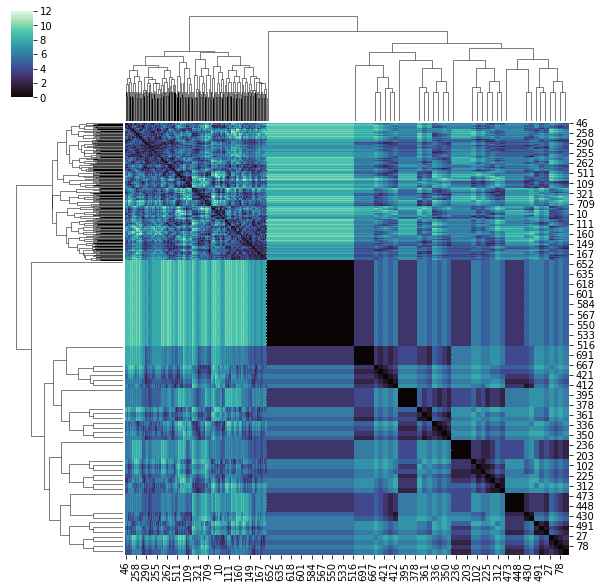

In [48]:
_ = PWEVisualization.cluster_map_viz(dist_matrix)

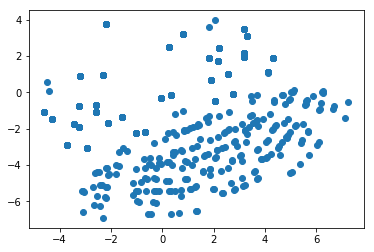

In [49]:
_ = PWEVisualization.mds_sklearn(dist_matrix)

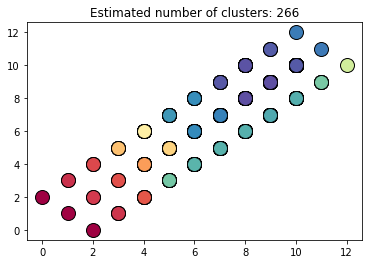

In [50]:
_ = PWEVisualization.dbscan_clustering(dist_matrix)

In [69]:
# YAY!

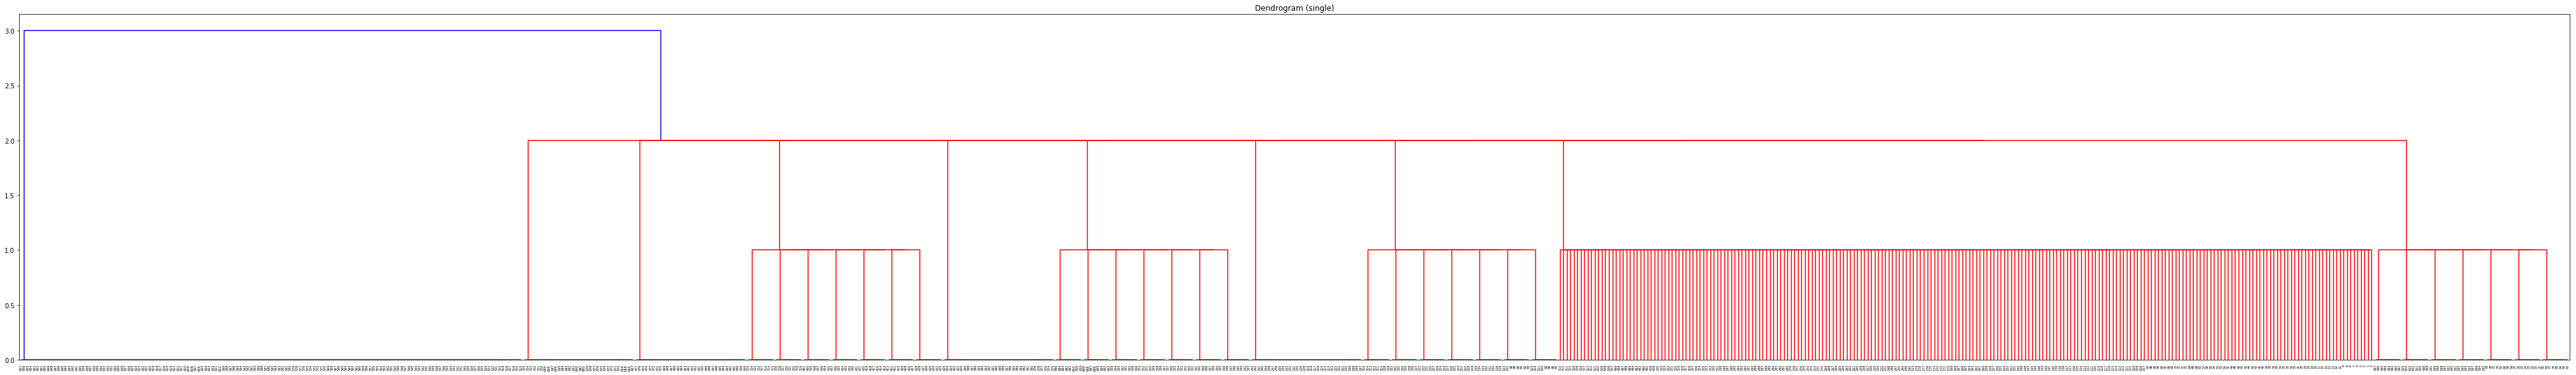

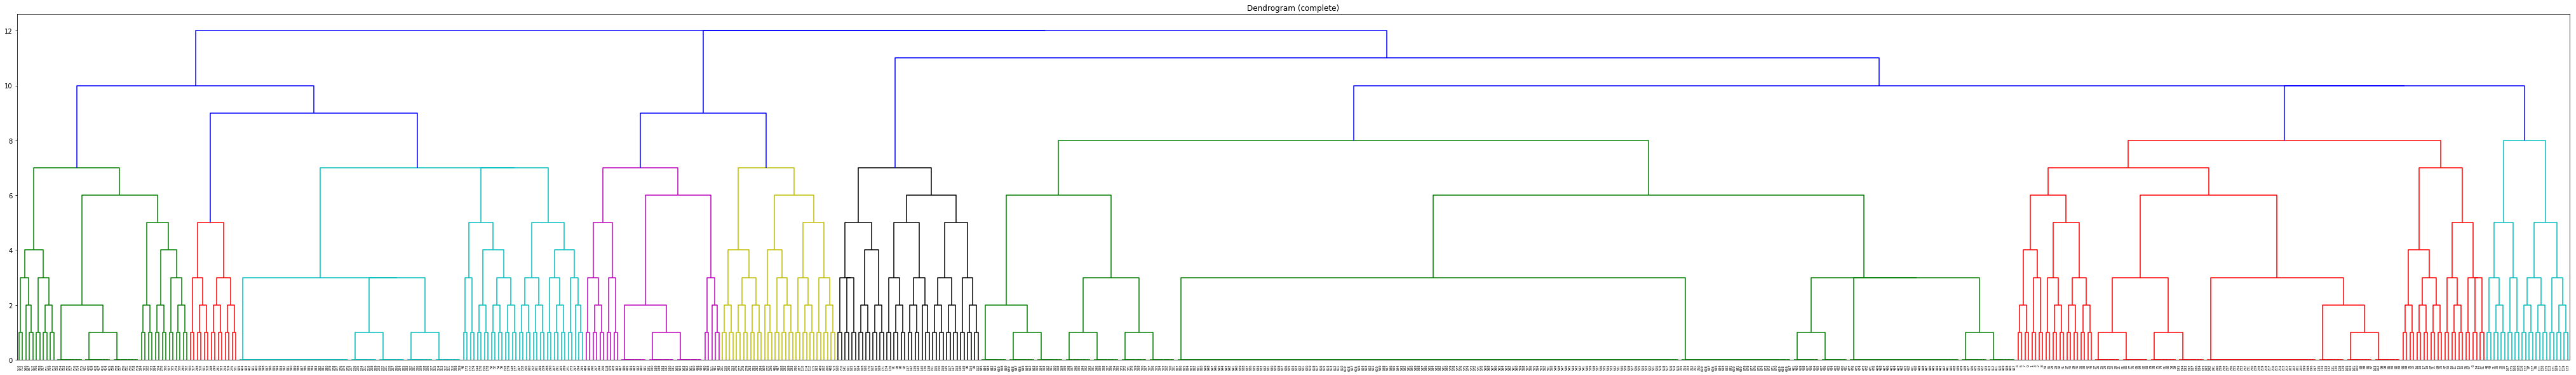

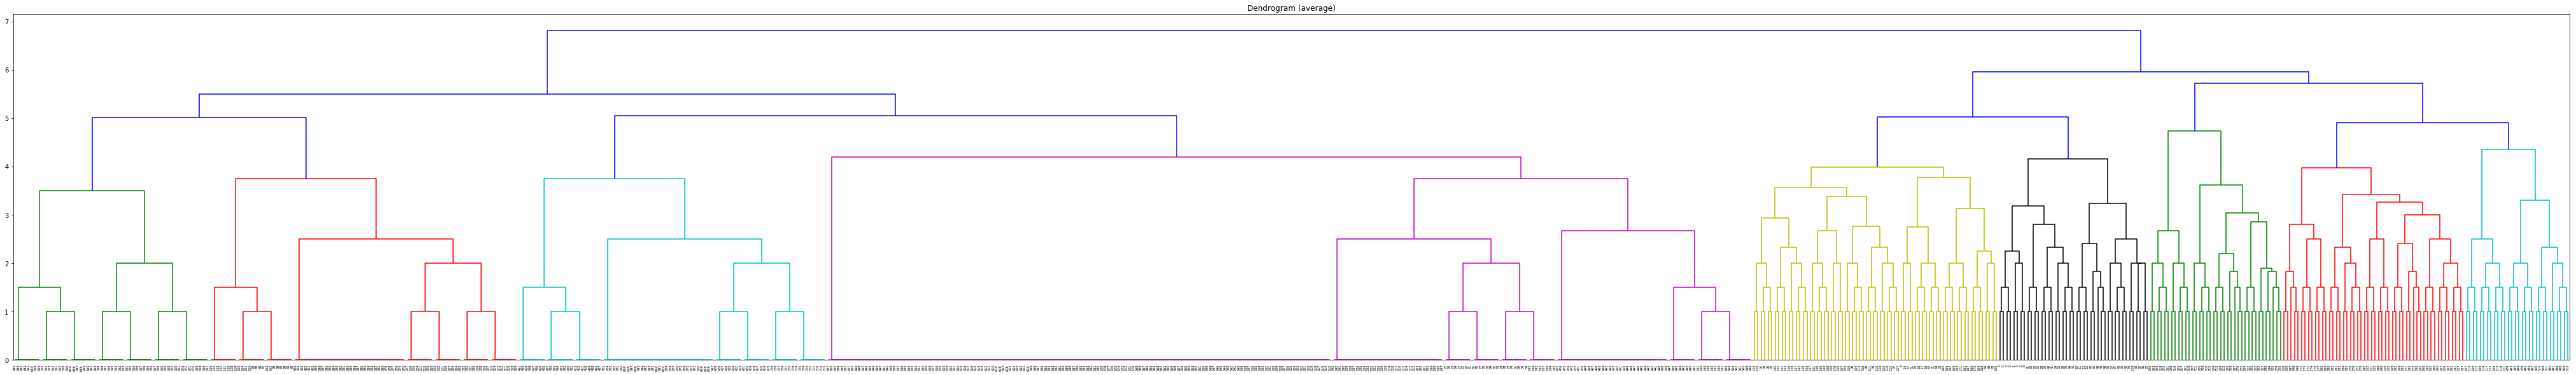

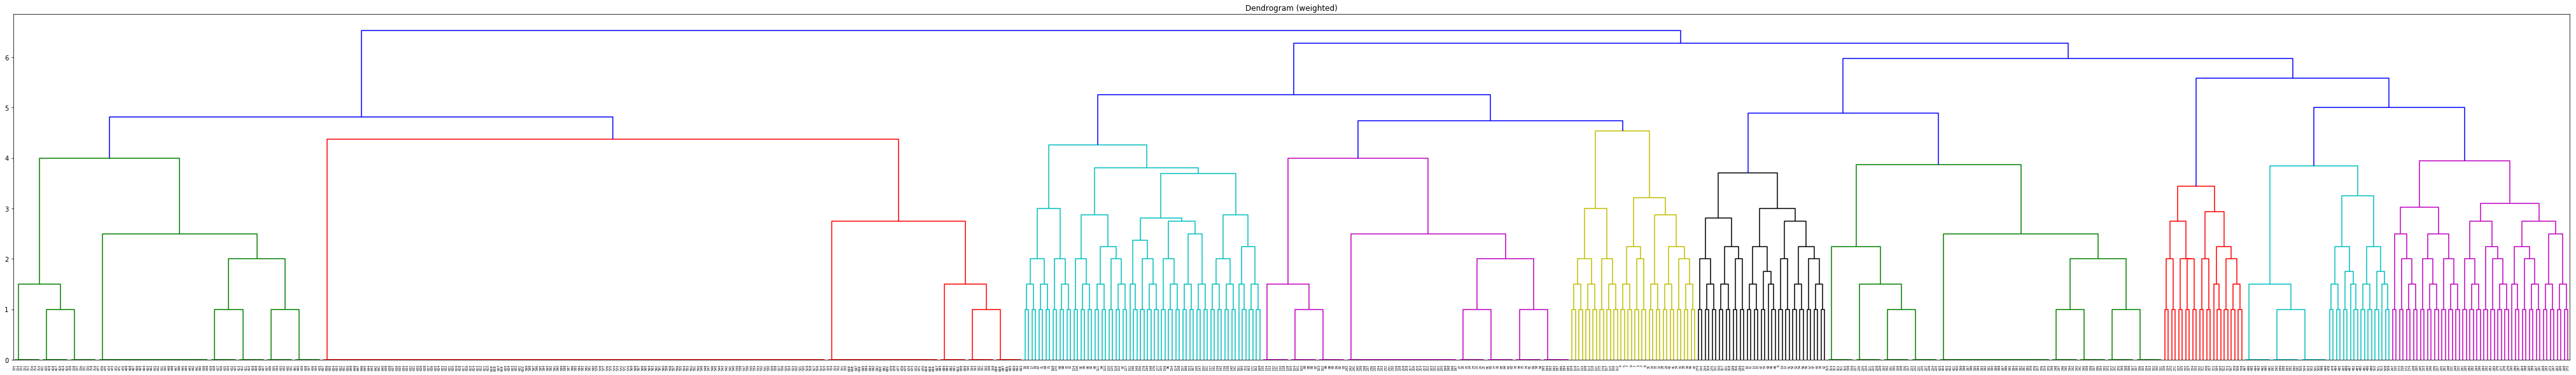

In [52]:
_ = PWEVisualization.linkage_dendrogram(dist_matrix)

In [53]:
# Very pretty, but hard to read tbh

In [90]:
vizs = {}
for q_rels, group in groups.items():
    group_vizs = []
    for pw_id in group:
        temp_dfs, _ = pw_slicer(potential_graphs['pw_rel_dfs'], None, [pw_id])
        g = PWEVisualization.graphviz_from_meta_data(temp_dfs, potential_graphs['meta_data']['graphviz'])
        g = mod_g(g)
        group_vizs.append(g)
        #display(draw(g, layout='neato'))
    vizs[q_rels] = group_vizs

In [111]:
import os

In [114]:
os.makedirs('Vizs', exist_ok=True)
for i, (_, g_vizs) in enumerate(vizs.items()):
    if len(g_vizs) > 1:
        os.makedirs("Vizs/group_{}".format(str(i+1)))
        for j, g in enumerate(g_vizs):
            draw(g, layout='neato', filename='Vizs/group_{}/ex_{}.{}'.format(str(i+1), str(j+1), 'png'))
    else:
        draw(g_vizs[0], layout='neato', filename='Vizs/group_{}.{}'.format(str(i+1), 'png'))

In [ ]:
#group 265 --> shows that current encoding actually records edges on some "walk" b/w a and f rather than "path"
#group 253 --> all ways to add 0 or more edges s.t. there are no walks from a to f.

In [117]:
%%dlv --donot-run --donot-display_input -lci remove_cycles


nn(A) :- e(A,_).
nn(A) :- e(_,A).

:- tc(A,B), tc(B,A), nn(A), nn(B).

In [119]:
%dlv -l g_e3 gen_new_edges remove_back_edges tc remove_cycles tc4 --donot-display_input --donot-display_output -exp potential_graphs_no_cycles

In [120]:
potential_graphs_no_cycles['pw_rel_dfs'], potential_graphs_no_cycles['rel_schemas'], potential_graphs_no_cycles['pw_objects'] = load_worlds(potential_graphs_no_cycles['asp_soln'], potential_graphs_no_cycles['meta_data'], reasoner='dlv')

Number of Models: 543


In [121]:
groups = {}
q_2_df = potential_graphs_no_cycles['pw_rel_dfs']['q_2']
for pw_id in range(1, len(potential_graphs_no_cycles['pw_objects'])+1):
    pw_q_2_df = q_2_df[q_2_df['pw'] == pw_id]
    pw_q_rels = []
    for i, row in pw_q_2_df.iterrows():
        pw_q_rels.append((row['x1'], row['x2']))
    pw_q_rels = frozenset(pw_q_rels)
    if pw_q_rels not in groups:
        groups[pw_q_rels] = []
    groups[pw_q_rels].append(pw_id)

In [122]:
len(groups.keys())

136

In [123]:
dist_matrix = np.zeros((len(potential_graphs_no_cycles['pw_objects']), len(potential_graphs_no_cycles['pw_objects'])))
q_2_df = potential_graphs_no_cycles['pw_rel_dfs']['q_2']
q_sets = list(map(lambda pw_id: get_pw_q_rels(q_2_df, pw_id), range(1, len(potential_graphs_no_cycles['pw_objects'])+1)))
for i in range(len(potential_graphs_no_cycles['pw_objects'])):
    for j in range(i+1, len(potential_graphs_no_cycles['pw_objects'])):
        dist_matrix[i][j] = dist_matrix[j][i] = compare_q_sets(q_sets[i], q_sets[j])
dist_matrix

array([[0., 1., 1., ..., 7., 7., 7.],
       [1., 0., 2., ..., 8., 8., 8.],
       [1., 2., 0., ..., 6., 6., 6.],
       ...,
       [7., 8., 6., ..., 0., 0., 0.],
       [7., 8., 6., ..., 0., 0., 0.],
       [7., 8., 6., ..., 0., 0., 0.]])

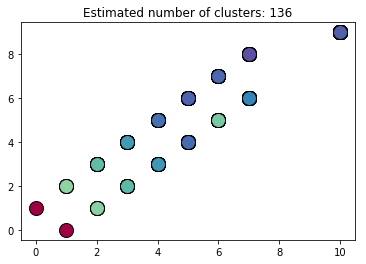

In [124]:
_ = PWEVisualization.dbscan_clustering(dist_matrix)

In [125]:
vizs_no_cycles = {}
for q_rels, group in groups.items():
    group_vizs_no_cycles = []
    for pw_id in group:
        temp_dfs, _ = pw_slicer(potential_graphs_no_cycles['pw_rel_dfs'], None, [pw_id])
        g = PWEVisualization.graphviz_from_meta_data(temp_dfs, potential_graphs_no_cycles['meta_data']['graphviz'])
        g = mod_g(g)
        group_vizs_no_cycles.append(g)
        #display(draw(g, layout='neato'))
    vizs_no_cycles[q_rels] = group_vizs_no_cycles

In [126]:
os.makedirs('Vizs_no_cycles', exist_ok=True)
for i, (_, g_vizs) in enumerate(vizs_no_cycles.items()):
    if len(g_vizs) > 1:
        os.makedirs("Vizs_no_cycles/group_{}".format(str(i+1)))
        for j, g in enumerate(g_vizs):
            draw(g, layout='neato', filename='Vizs_no_cycles/group_{}/ex_{}.{}'.format(str(i+1), str(j+1), 'png'))
    else:
        draw(g_vizs[0], layout='neato', filename='Vizs_no_cycles/group_{}.{}'.format(str(i+1), 'png'))

In [127]:
groups_no_cycles = groups

In [128]:
groups = {}
q_2_df = potential_graphs['pw_rel_dfs']['q_2']
for pw_id in range(1, len(potential_graphs['pw_objects'])+1):
    pw_q_2_df = q_2_df[q_2_df['pw'] == pw_id]
    pw_q_rels = []
    for i, row in pw_q_2_df.iterrows():
        pw_q_rels.append((row['x1'], row['x2']))
    pw_q_rels = frozenset(pw_q_rels)
    if pw_q_rels not in groups:
        groups[pw_q_rels] = []
    groups[pw_q_rels].append(pw_id)

In [130]:
set(groups.keys()) >= set(groups_no_cycles.keys())

True

In [133]:
print(", ".join([str(len(s)) for k,s in groups_no_cycles.items()]))

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 1, 1, 1, 1, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 32, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 32, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 1, 1, 1, 1, 8, 32, 1, 1, 1, 1, 8, 8, 8, 8, 144, 8, 32, 1, 8
